In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import xarray as xr

from scipy import stats
from scipy import integrate
from numpy import exp
import math

from osgeo import gdal
#from gistool import rasterize
import pyhdf
from pyhdf.SD import SD
import geopandas as gpd
import rasterio
import rioxarray as rxr

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib.colors as mcolors
plt.rcParams['font.family'] = 'Arial'

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import cartopy.feature as cfeature
import cartopy.io.shapereader as shapereader

import shap
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from matplotlib import font_manager
font_path = "/portal1/dell/li-b/font/ARIAL.TTF"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
# print(prop.get_name())  # 显示当前使用字体的名称

# 字体设置
plt.rcParams['font.family'] = 'ARIAL' # 使用字体中的无衬线体
# plt.rcParams['font.sans-serif'] = prop.get_name()  # 根据名称设置字体
# plt.rcParams['font.size'] = 10 # 设置字体大小
# plt.rcParams['axes.unicode_minus'] = False # 使坐标轴刻度标签正常显示正负号

In [3]:
# inpath = 'C:/Users/bn_li/Desktop/manu1/data/'
inpath = '/portal1/dell/li-b/manu1/data/'
# outpath = 'D:/figs_manu1/'
outpath = '/portal1/dell/li-b/manu1/figs/'

## pre

In [8]:
mask = xr.open_dataset(inpath+'lc.nc')
mask1 = xr.open_dataset(inpath+'spi_mask.nc')

def varimask_forest(ds):

    x = ds.dims['lon']
    y = ds.dims['lat']
    
    mask_a = mask['vari'].values == 1
    mask_b = mask1['vari'].values <= 0
    combined_mask = mask_a & mask_b  # Logical AND
    
    ratio = np.sum(combined_mask) / np.sum(mask_a) * 100
    print(f"Forest mask ratio: {ratio:.2f}%")
    
    anos = np.full_like(ds['vari'].values, np.nan)
    for t in range(ds.dims['time']):    #### change the time length
        vari_t = ds['vari'][t,:,:].values
        vari_masked = np.where(combined_mask, vari_t, np.nan)
        arr = vari_masked.copy() #### exclude sichuan mountaions 
        arr[:80,:51] = np.nan
        anos[t,:,:] = arr
        
    ds_ex = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                                coords={ 'time': (['time'], ds.time.values),
                                        'lat': (['lat'], ds.lat.values),
                                        'lon': (['lon'], ds.lon.values)})
    return(ds_ex)

def varimask_shrub(ds):

    x = ds.dims['lon']
    y = ds.dims['lat']
    
    mask_a = mask['vari'].values == 2
    mask_b = mask1['vari'].values <= 0
    combined_mask = mask_a & mask_b  # Logical AND
    
    ratio = np.sum(combined_mask) / np.sum(mask_a) * 100
    print(f"Shrubland mask ratio: {ratio:.2f}%")
    
    anos = np.full_like(ds['vari'].values, np.nan)
    for t in range(ds.dims['time']):    #### change the time length
        vari_t = ds['vari'][t,:,:].values
        vari_masked = np.where(combined_mask, vari_t, np.nan)
        anos[t,:,:] = vari_masked
        
    ds_ex = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                                coords={ 'time': (['time'], ds.time.values),
                                        'lat': (['lat'], ds.lat.values),
                                        'lon': (['lon'], ds.lon.values)})
    return(ds_ex)


def varimask_crop(ds):

    x = ds.dims['lon']
    y = ds.dims['lat']
    
    mask_a = mask['vari'].values == 5
    mask_b = mask1['vari'].values <= 0
    combined_mask = mask_a & mask_b  # Logical AND
    
    ratio = np.sum(combined_mask) / np.sum(mask_a) * 100
    print(f"Crop mask ratio: {ratio:.2f}%")
    
    anos = np.full_like(ds['vari'].values, np.nan)
    for t in range(ds.dims['time']):    #### change the time length
        vari_t = ds['vari'][t,:,:].values
        vari_masked = np.where(combined_mask, vari_t, np.nan)
        anos[t,:,:] = vari_masked
        
    ds_ex = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                                coords={ 'time': (['time'], ds.time.values),
                                        'lat': (['lat'], ds.lat.values),
                                        'lon': (['lon'], ds.lon.values)})
    return(ds_ex)

In [9]:
def moving_window_mean(da, size=3):
    """
    Compute spatial moving window mean for each pixel.
    da: xarray.DataArray with dims (time, lat, lon)
    size: window size (odd number, e.g., 3)
    """
    return da.rolling(lat=size, lon=size, center=True).mean()

## cal daily anos

In [4]:
datasets = {
    "x1": xr.open_dataset(inpath+'shapley/pre_0.05.nc'),
    "x2": xr.open_dataset(inpath+'shapley/rn_0.05.nc'),
    "x3": xr.open_dataset(inpath+'shapley/sm_new_0.05_1d.nc'),
    "x4": xr.open_dataset(inpath+'shapley/t_0.05.nc'),
    "x5": xr.open_dataset(inpath+'shapley/vpd_0.05.nc'), ####### kpa
    "y1": xr.open_dataset(inpath+'shapley/lai_new_qc_0.05_1d.nc'),
    "y2": xr.open_dataset(inpath+'shapley/sif_0.05_1d.nc'),
    "y3": xr.open_dataset(inpath+'shapley/ndvi_new_qc_0.05_1d.nc')
}

# Loop through datasets and print min/max for 'vari'
for name, ds in datasets.items():
    var_data = ds['vari']
    min_val = float(var_data.min().values)
    max_val = float(var_data.max().values)
    mean_val = float(var_data.mean().values)
    print(f"{name}: min = {min_val}, max = {max_val}, mean = {mean_val}")

x1: min = 0.0, max = 620.4110107421875, mean = 3.8455889225006104
x2: min = 478663.4375, max = 20381528.0, mean = 11739076.0
x3: min = 0.0, max = 1.1128389835357666, mean = 0.3248665347488979
x4: min = -9.992633819580078, max = 36.673343658447266, mean = 18.21828269958496
x5: min = 1.0679335105123755e-07, max = 3.8293213844299316, mean = 0.5838751792907715
y1: min = 0.0, max = 8.355465487744482, mean = 1.7187833738814817
y2: min = -0.3190893530845642, max = 1.4170148372650146, mean = 0.19648294321807686
y3: min = -0.19999998807907104, max = 0.9978999495506287, mean = 0.5747638084420842


In [4]:
x1 = xr.open_dataset(inpath+'shapley/pre_0.05.nc')
x2 = xr.open_dataset(inpath+'shapley/rn_0.05.nc')
x3 = xr.open_dataset(inpath+'shapley/sm_new_0.05_1d.nc')
x4 = xr.open_dataset(inpath+'shapley/t_0.05.nc')
x5 = xr.open_dataset(inpath+'shapley/vpd_0.05.nc')
y1 = xr.open_dataset(inpath+'shapley/lai_new_qc_0.05_1d.nc')
y2 = xr.open_dataset(inpath+'shapley/sif_0.05_1d.nc')
y3_0 = xr.open_dataset(inpath+'shapley/ndvi_new_qc_0.05_1d.nc')

x3['vari'] = x3['vari'].where(x3['vari'] <= 1)
y2['vari'] = y2['vari'].where(y2['vari'] >= 0)
times = pd.date_range(start='2000-02-18', end='2025-08-13', freq='D')
y3 = xr.Dataset({'vari': (['time','lat','lon'], y3_0['vari'].values)},
                                coords={ 'time': (['time'], times),
                                        'lat': (['lat'], y3_0.lat.values),
                                        'lon': (['lon'], y3_0.lon.values)})

In [5]:
def compute_anomaly_xarray_fast(ds):
    da = ds["vari"].sortby("time")

    # Jul–Sep 2001–2022
    time_index = pd.to_datetime(da["time"].values)
    mask = (
        (time_index.year >= 2001) &
        (time_index.year <= 2022) &
        (np.isin(time_index.month, [7,8,9]))
    )
    da_win = da.sel(time=da.time[mask])

    # Vectorized deseasonalization
    doy = da_win["time"].dt.dayofyear
    clim = da_win.groupby(doy).mean(dim="time")
    anom_deseasonal = da_win.groupby(doy) - clim

    # # Fast rolling trend (replace LOWESS)
    # trend = anom_deseasonal.rolling(time=5, center=True).mean()
    # anom_final = anom_deseasonal - trend

    return anom_deseasonal

In [6]:
x1_1 = compute_anomaly_xarray_fast(x1).to_dataset(name="vari")
x2_1 = compute_anomaly_xarray_fast(x2).to_dataset(name="vari")
x3_1 = compute_anomaly_xarray_fast(x3).to_dataset(name="vari")
x4_1 = compute_anomaly_xarray_fast(x4).to_dataset(name="vari")
x5_1 = compute_anomaly_xarray_fast(x5).to_dataset(name="vari")
y1_1 = compute_anomaly_xarray_fast(y1).to_dataset(name="vari")
y2_1 = compute_anomaly_xarray_fast(y2).to_dataset(name="vari")
y3_1 = compute_anomaly_xarray_fast(y3).to_dataset(name="vari")

## shap

In [10]:
################# x1-pre, x2-rn, x3-sm, x4-t, x5-vpd, y1-lai, y2-sif, y3-ndvi ##############################
ds_y1 = varimask_forest(y1_1).sel(time=slice('2022-07-01','2022-09-30'))
ds_y2 = varimask_forest(y2_1).sel(time=slice('2022-07-01','2022-09-30'))
ds_y3 = varimask_forest(y3_1).sel(time=slice('2022-07-01','2022-09-30'))
ds_x1 = varimask_forest(x1_1).sel(time=slice('2022-07-01','2022-09-30'))
ds_x2 = varimask_forest(x2_1).sel(time=slice('2022-07-01','2022-09-30'))
ds_x3 = varimask_forest(x3_1).sel(time=slice('2022-07-01','2022-09-30'))
ds_x4 = varimask_forest(x4_1).sel(time=slice('2022-07-01','2022-09-30'))
ds_x5 = varimask_forest(x5_1).sel(time=slice('2022-07-01','2022-09-30'))

y1_smooth = moving_window_mean(ds_y1['vari'], size=3)
y2_smooth = moving_window_mean(ds_y2['vari'], size=3)
y3_smooth = moving_window_mean(ds_y3['vari'], size=3)
x1_smooth = moving_window_mean(ds_x1['vari'], size=3)
x2_smooth = moving_window_mean(ds_x2['vari'], size=3)
x3_smooth = moving_window_mean(ds_x3['vari'], size=3)
x4_smooth = moving_window_mean(ds_x4['vari'], size=3)
x5_smooth = moving_window_mean(ds_x5['vari'], size=3)

arr_y1 = y1_smooth.values.flatten()
arr_y2 = y2_smooth.values.flatten()
arr_y3 = y3_smooth.values.flatten()
arr_x1 = x1_smooth.values.flatten()
arr_x2 = x2_smooth.values.flatten()
arr_x3 = x3_smooth.values.flatten()
arr_x4 = x4_smooth.values.flatten()
arr_x5 = x5_smooth.values.flatten()

df = pd.DataFrame({'y': arr_y1, 'PRE': arr_x1, 'RN': arr_x2, 'SM': arr_x3, 'T': arr_x4, 'VPD': arr_x5})
df1 = df.dropna()
df = pd.DataFrame({'y': arr_y2, 'PRE': arr_x1, 'RN': arr_x2, 'SM': arr_x3, 'T': arr_x4, 'VPD': arr_x5})
df2 = df.dropna()
df = pd.DataFrame({'y': arr_y3, 'PRE': arr_x1, 'RN': arr_x2, 'SM': arr_x3, 'T': arr_x4, 'VPD': arr_x5})
df3 = df.dropna()

Forest mask ratio: 84.22%
Forest mask ratio: 84.22%
Forest mask ratio: 84.22%
Forest mask ratio: 84.22%
Forest mask ratio: 84.22%
Forest mask ratio: 84.22%
Forest mask ratio: 84.22%
Forest mask ratio: 84.22%


In [23]:
X1 = df1[['PRE', 'RN', 'SM', 'T', 'VPD']]  
y = df1['y'].values
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(
    n_estimators=1000,       # number of trees
    max_depth=6,             # maximum depth of each tree
    learning_rate=0.1,      # shrinkage for boosting
    subsample=0.9,           # fraction of samples per tree
    colsample_bytree=0.8,    # fraction of features per tree
    gamma=0,                 # minimum loss reduction to make a split
    reg_alpha=0.5,              # L1 regularization
    reg_lambda=1,             # L2 regularization
    min_child_weight=4,       # minimum sum of instance weight in a child
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.6f}")

X_sample1 = X1.sample(20000, random_state=42)
explainer = shap.Explainer(xgb_model,X_sample1)
shap_values1 = explainer(X_sample1)
shap_values_array1 = shap_values1.values
shap_values_mean1 = np.abs(shap_values_array1).mean(axis=0)


X2 = df2[['PRE', 'RN', 'SM', 'T', 'VPD']]  
y = df2['y'].values
X_train, X_test, y_train, y_test = train_test_split(
    X2, y, test_size=0.2, random_state=42, shuffle=True)

xgb_model = xgb.XGBRegressor(
    n_estimators=1000,       # number of trees
    max_depth=7,             # maximum depth of each tree
    learning_rate=0.1,      # shrinkage for boosting
    subsample=0.9,           # fraction of samples per tree
    colsample_bytree=0.8,    # fraction of features per tree
    gamma=0,                 # minimum loss reduction to make a split
    reg_alpha=0.5,              # L1 regularization
    reg_lambda=1,             # L2 regularization
    min_child_weight=4,       # minimum sum of instance weight in a child
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.6f}")

X_sample2 = X2.sample(20000, random_state=42)
explainer = shap.Explainer(xgb_model,X_sample2)
shap_values2 = explainer(X_sample2)
shap_values_array2 = shap_values2.values
shap_values_mean2 = np.abs(shap_values_array2).mean(axis=0)


X3 = df3[['PRE', 'RN', 'SM', 'T', 'VPD']]  
y = df3['y'].values
X_train, X_test, y_train, y_test = train_test_split(
    X3, y, test_size=0.2, random_state=42, shuffle=True)

xgb_model = xgb.XGBRegressor(
    n_estimators=1500,       # number of trees
    max_depth=8,             # maximum depth of each tree
    learning_rate=0.1,      # shrinkage for boosting
    subsample=0.9,           # fraction of samples per tree
    colsample_bytree=0.8,    # fraction of features per tree
    gamma=0,                 # minimum loss reduction to make a split
    reg_alpha=0.1,              # L1 regularization
    reg_lambda=1,             # L2 regularization
    min_child_weight=4,       # minimum sum of instance weight in a child
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.6f}")

X_sample3 = X3.sample(20000, random_state=42)
explainer = shap.Explainer(xgb_model,X_sample3)
shap_values3 = explainer(X_sample3)
shap_values_array3 = shap_values3.values
shap_values_mean3 = np.abs(shap_values_array3).mean(axis=0)

R²: 0.6375
MSE: 0.037839


100%|===================| 19991/20000 [14:17<00:00]        

R²: 0.6137
MSE: 0.000720


100%|===================| 19985/20000 [21:23<00:00]        

R²: 0.6027
MSE: 0.000139


100%|===================| 19993/20000 [39:16<00:00]        

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


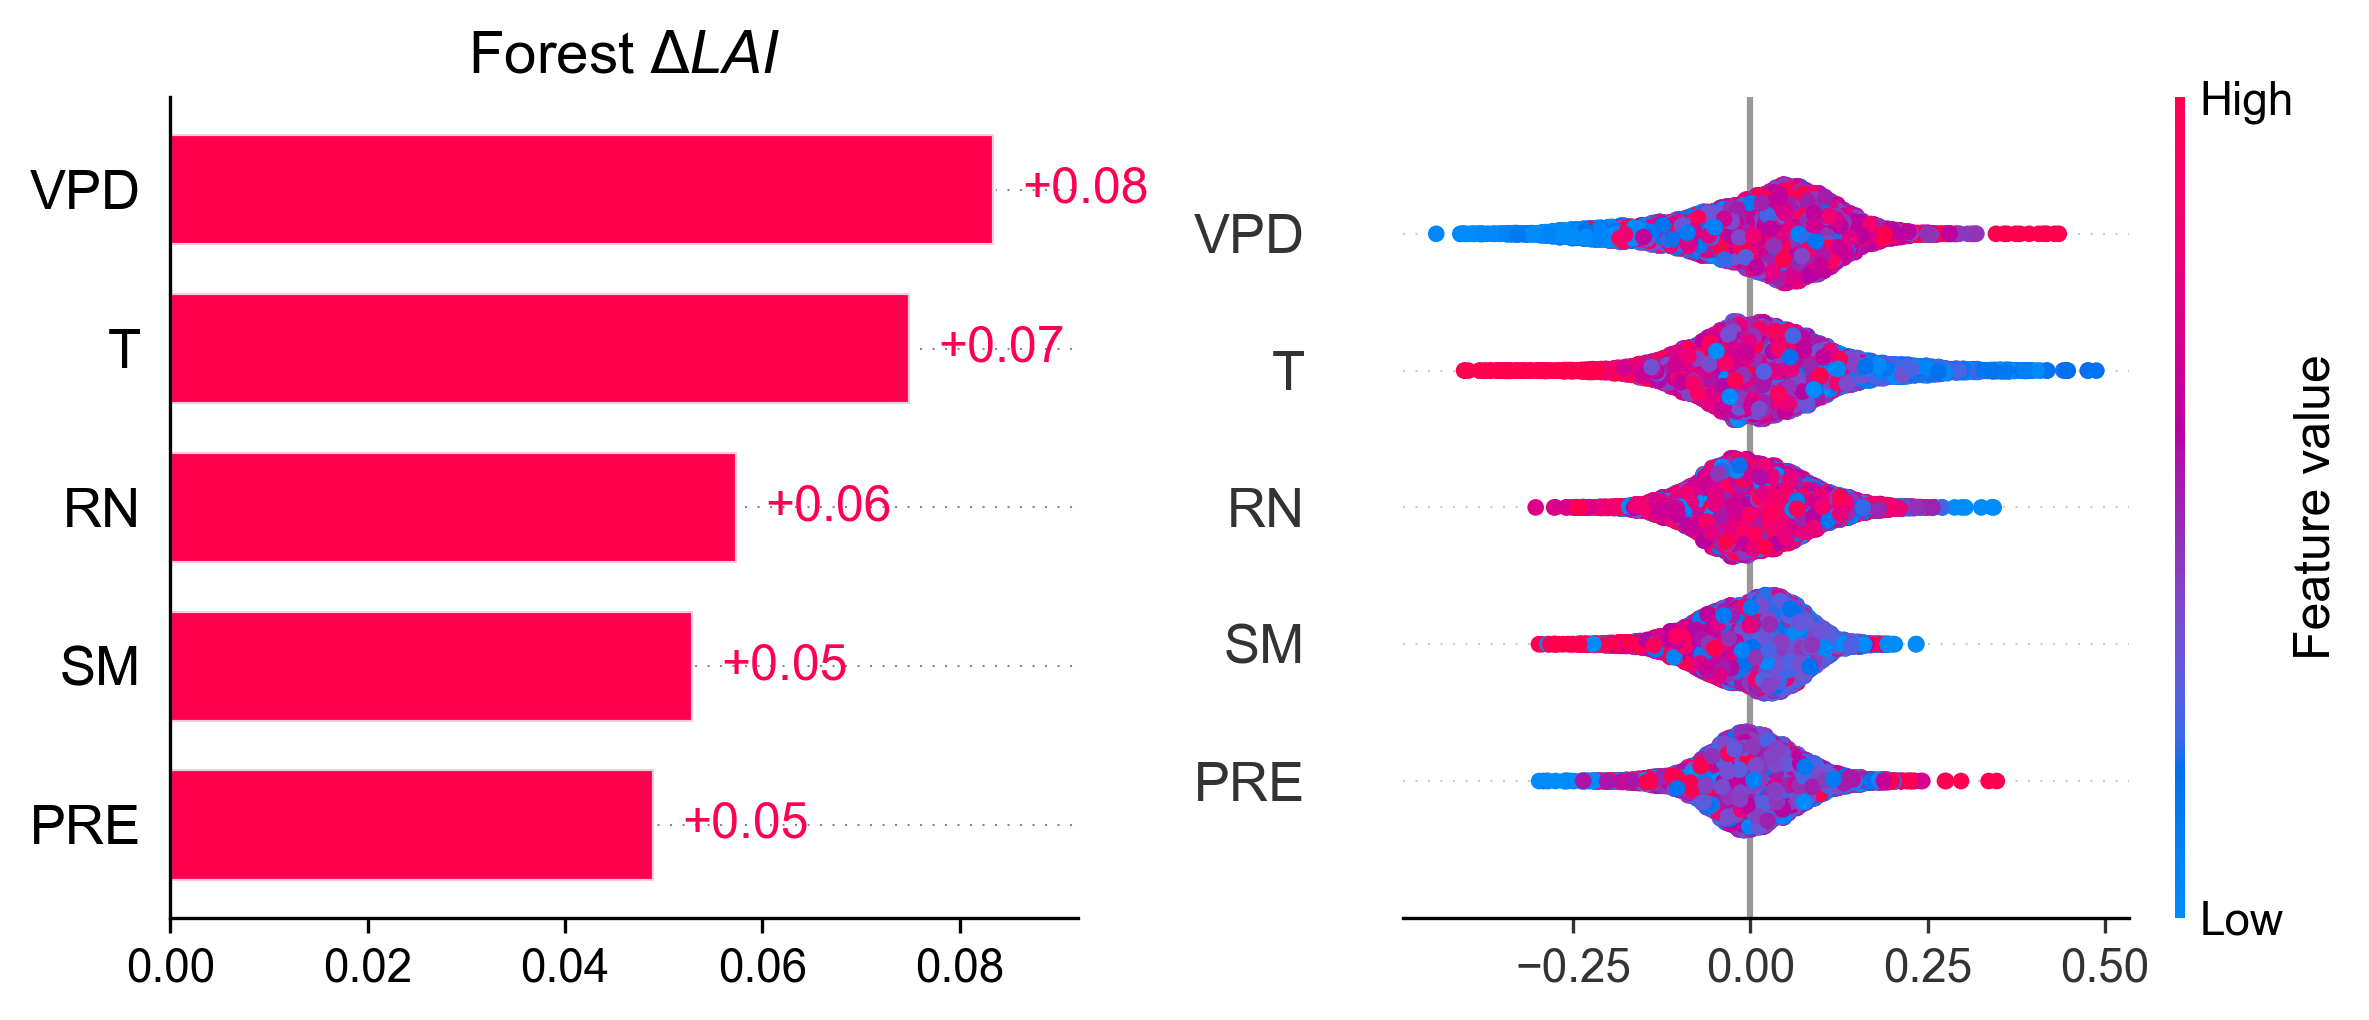

In [24]:
fig, axs = plt.subplots(1, 2, dpi=300, figsize=(6, 4))
shap.plots.bar(shap_values1, show=False, ax=axs[0])
axs[0].set_title("Forest $\Delta LAI$", fontsize=14)
axs[0].set_xlabel('')
shap.summary_plot(shap_values_array1, X_sample1, show=False)
axs[1].set_xlabel('')
plt.tight_layout()
plt.savefig(outpath+'r1a1.eps', dpi=1000, bbox_inches='tight') 
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


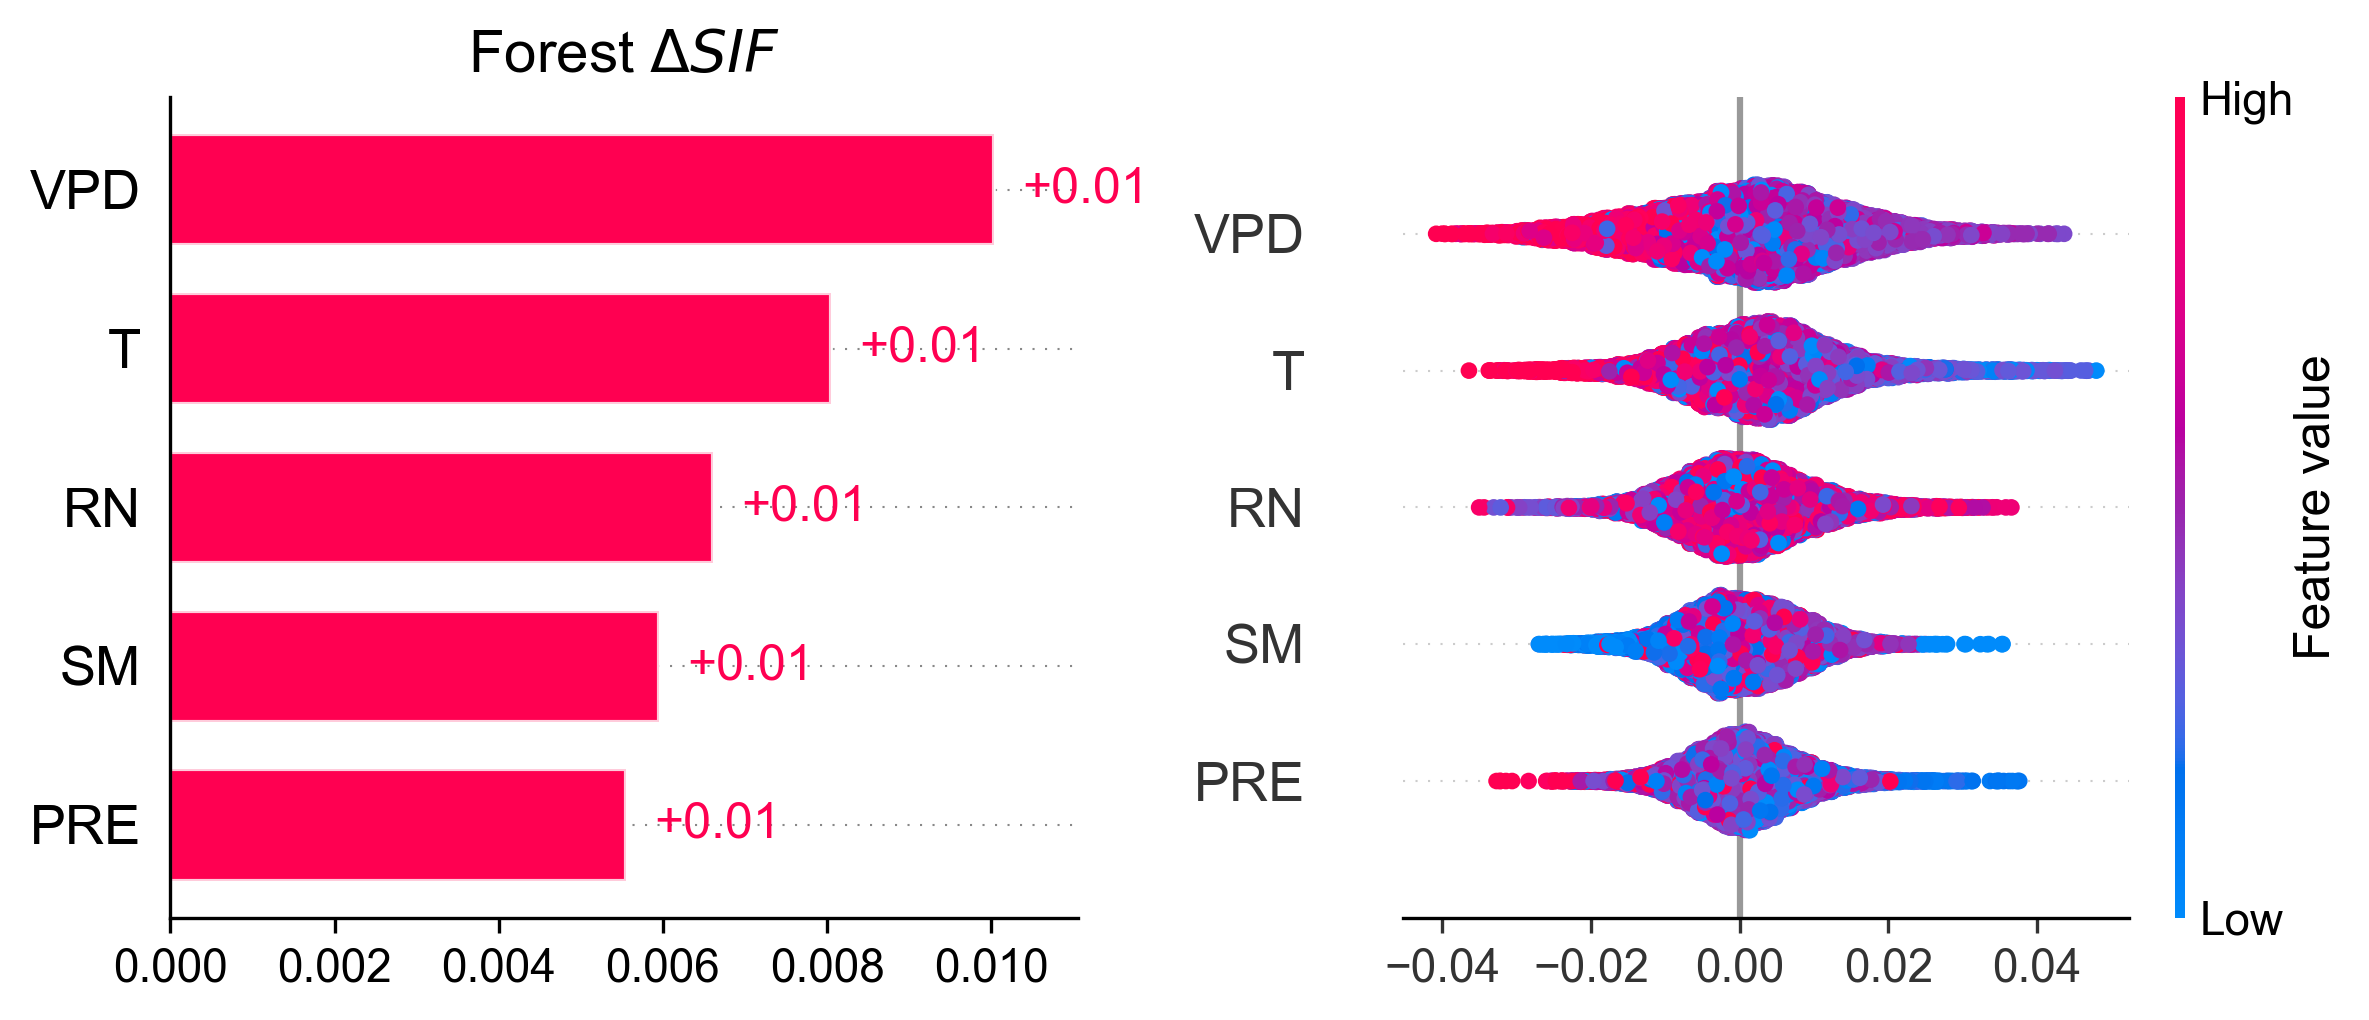

In [25]:
fig, axs = plt.subplots(1, 2, dpi=300, figsize=(6, 4))
shap.plots.bar(shap_values2, show=False, ax=axs[0])
axs[0].set_title("Forest $\Delta SIF$", fontsize=14)
axs[0].set_xlabel('')
shap.summary_plot(shap_values_array2, X_sample2, show=False)
plt.gca().set_xlabel('')
plt.tight_layout()
plt.savefig(outpath+'r1a2.eps', dpi=1000, bbox_inches='tight') 
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


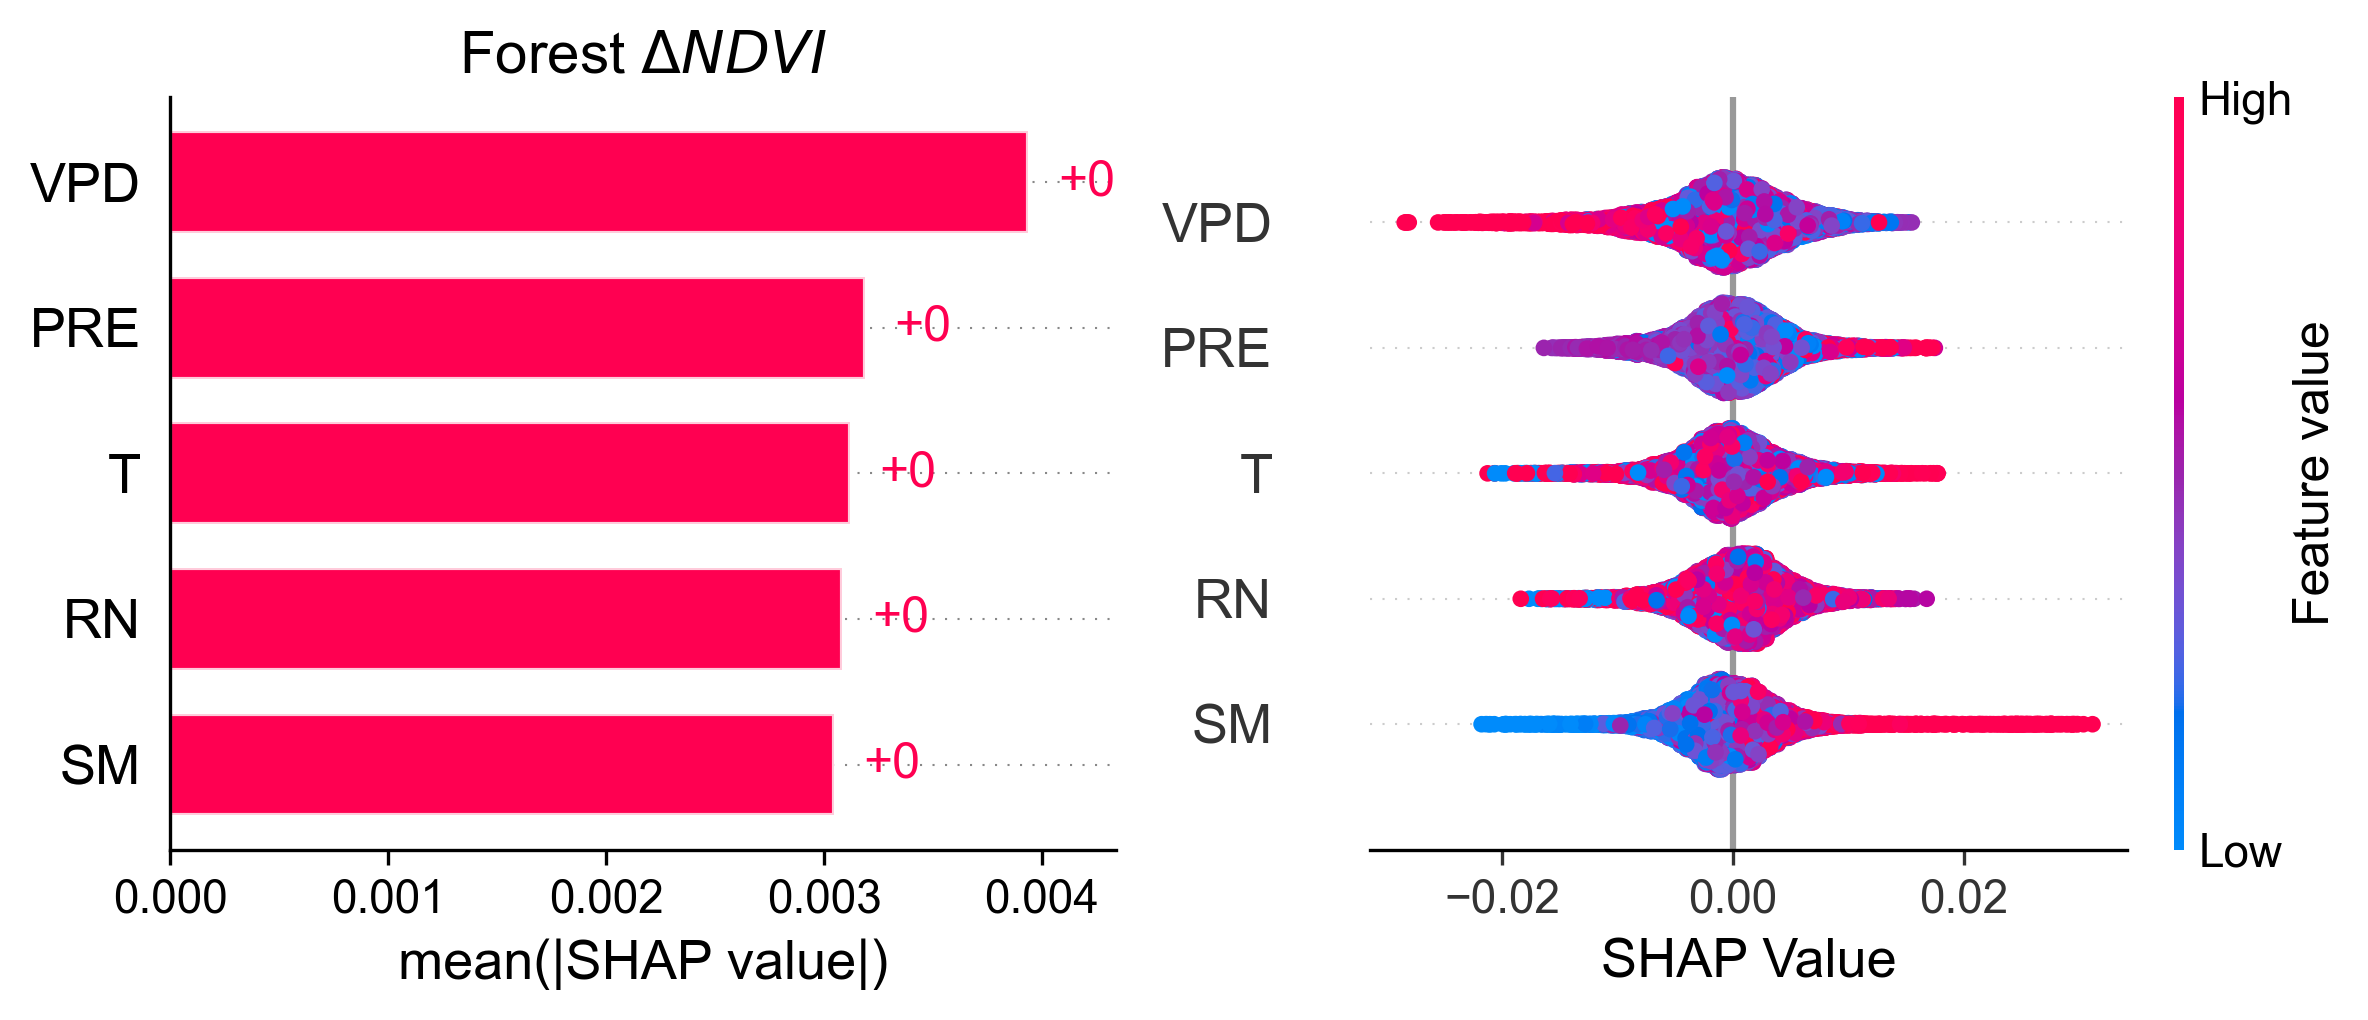

In [26]:
fig, axs = plt.subplots(1, 2, dpi=300, figsize=(6, 4))
shap.plots.bar(shap_values3, show=False, ax=axs[0])
axs[0].set_title("Forest $\Delta NDVI$", fontsize=14)
shap.summary_plot(shap_values_array3, X_sample3, show=False)
plt.gca().set_xlabel('SHAP Value')
plt.tight_layout()
plt.savefig(outpath+'r1a3.eps', dpi=1000, bbox_inches='tight') 
plt.show()

In [27]:
################# x1-pre, x2-rn, x3-sm, x4-t, x5-vpd, y1-lai, y2-sif, y3-ndvi ##############################
ds_y1 = varimask_shrub(y1_1).sel(time=slice('2022-07-01','2022-09-30'))
ds_y2 = varimask_shrub(y2_1).sel(time=slice('2022-07-01','2022-09-30'))
ds_y3 = varimask_shrub(y3_1).sel(time=slice('2022-07-01','2022-09-30'))
ds_x1 = varimask_shrub(x1_1).sel(time=slice('2022-07-01','2022-09-30'))
ds_x2 = varimask_shrub(x2_1).sel(time=slice('2022-07-01','2022-09-30'))
ds_x3 = varimask_shrub(x3_1).sel(time=slice('2022-07-01','2022-09-30'))
ds_x4 = varimask_shrub(x4_1).sel(time=slice('2022-07-01','2022-09-30'))
ds_x5 = varimask_shrub(x5_1).sel(time=slice('2022-07-01','2022-09-30'))

y1_smooth = moving_window_mean(ds_y1['vari'], size=3)
y2_smooth = moving_window_mean(ds_y2['vari'], size=3)
y3_smooth = moving_window_mean(ds_y3['vari'], size=3)
x1_smooth = moving_window_mean(ds_x1['vari'], size=3)
x2_smooth = moving_window_mean(ds_x2['vari'], size=3)
x3_smooth = moving_window_mean(ds_x3['vari'], size=3)
x4_smooth = moving_window_mean(ds_x4['vari'], size=3)
x5_smooth = moving_window_mean(ds_x5['vari'], size=3)

arr_y1 = y1_smooth.values.flatten()
arr_y2 = y2_smooth.values.flatten()
arr_y3 = y3_smooth.values.flatten()
arr_x1 = x1_smooth.values.flatten()
arr_x2 = x2_smooth.values.flatten()
arr_x3 = x3_smooth.values.flatten()
arr_x4 = x4_smooth.values.flatten()
arr_x5 = x5_smooth.values.flatten()

df = pd.DataFrame({'y': arr_y1, 'PRE': arr_x1, 'RN': arr_x2, 'SM': arr_x3, 'T': arr_x4, 'VPD': arr_x5})
df1 = df.dropna()
df = pd.DataFrame({'y': arr_y2, 'PRE': arr_x1, 'RN': arr_x2, 'SM': arr_x3, 'T': arr_x4, 'VPD': arr_x5})
df2 = df.dropna()
df = pd.DataFrame({'y': arr_y3, 'PRE': arr_x1, 'RN': arr_x2, 'SM': arr_x3, 'T': arr_x4, 'VPD': arr_x5})
df3 = df.dropna()

Shrubland mask ratio: 87.93%
Shrubland mask ratio: 87.93%
Shrubland mask ratio: 87.93%
Shrubland mask ratio: 87.93%
Shrubland mask ratio: 87.93%
Shrubland mask ratio: 87.93%
Shrubland mask ratio: 87.93%
Shrubland mask ratio: 87.93%


In [49]:
X1 = df1[['PRE', 'RN', 'SM', 'T', 'VPD']]  
y = df1['y'].values
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(
    n_estimators=1500,       # number of trees
    max_depth=8,             # maximum depth of each tree
    learning_rate=0.1,      # shrinkage for boosting
    subsample=0.9,           # fraction of samples per tree
    colsample_bytree=0.8,    # fraction of features per tree
    gamma=0,                 # minimum loss reduction to make a split
    reg_alpha=0.5,              # L1 regularization
    reg_lambda=1,             # L2 regularization
    min_child_weight=4,       # minimum sum of instance weight in a child
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.6f}")

X_sample1 = X1.sample(20000, random_state=42)
explainer = shap.Explainer(xgb_model,X_sample1)
shap_values1 = explainer(X_sample1)
shap_values_array1 = shap_values1.values
shap_values_mean1 = np.abs(shap_values_array1).mean(axis=0)


X2 = df2[['PRE', 'RN', 'SM', 'T', 'VPD']]  
y = df2['y'].values
X_train, X_test, y_train, y_test = train_test_split(
    X2, y, test_size=0.2, random_state=42, shuffle=True)

xgb_model = xgb.XGBRegressor(
    n_estimators=1500,       # number of trees
    max_depth=9,             # maximum depth of each tree
    learning_rate=0.1,      # shrinkage for boosting
    subsample=0.9,           # fraction of samples per tree
    colsample_bytree=0.8,    # fraction of features per tree
    gamma=0,                 # minimum loss reduction to make a split
    reg_alpha=0.1,              # L1 regularization
    reg_lambda=1,             # L2 regularization
    min_child_weight=4,       # minimum sum of instance weight in a child
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.6f}")

X_sample2 = X2.sample(20000, random_state=42)
explainer = shap.Explainer(xgb_model,X_sample2)
shap_values2 = explainer(X_sample2)
shap_values_array2 = shap_values2.values
shap_values_mean2 = np.abs(shap_values_array2).mean(axis=0)


X3 = df3[['PRE', 'RN', 'SM', 'T', 'VPD']]  
y = df3['y'].values
X_train, X_test, y_train, y_test = train_test_split(
    X3, y, test_size=0.2, random_state=42, shuffle=True)

xgb_model = xgb.XGBRegressor(
    n_estimators=1500,       # number of trees
    max_depth=8,             # maximum depth of each tree
    learning_rate=0.1,      # shrinkage for boosting
    subsample=0.9,           # fraction of samples per tree
    colsample_bytree=0.8,    # fraction of features per tree
    gamma=0,                 # minimum loss reduction to make a split
    reg_alpha=0.1,              # L1 regularization
    reg_lambda=1,             # L2 regularization
    min_child_weight=4,       # minimum sum of instance weight in a child
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.6f}")

X_sample3 = X3.sample(20000, random_state=42)
explainer = shap.Explainer(xgb_model,X_sample3)
shap_values3 = explainer(X_sample3)
shap_values_array3 = shap_values3.values
shap_values_mean3 = np.abs(shap_values_array3).mean(axis=0)

R²: 0.6002
MSE: 0.021622


100%|===================| 19999/20000 [34:07<00:00]        

R²: 0.6266
MSE: 0.000497


100%|===================| 19999/20000 [49:28<00:00]        

R²: 0.6406
MSE: 0.000433


100%|===================| 19992/20000 [35:52<00:00]        

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


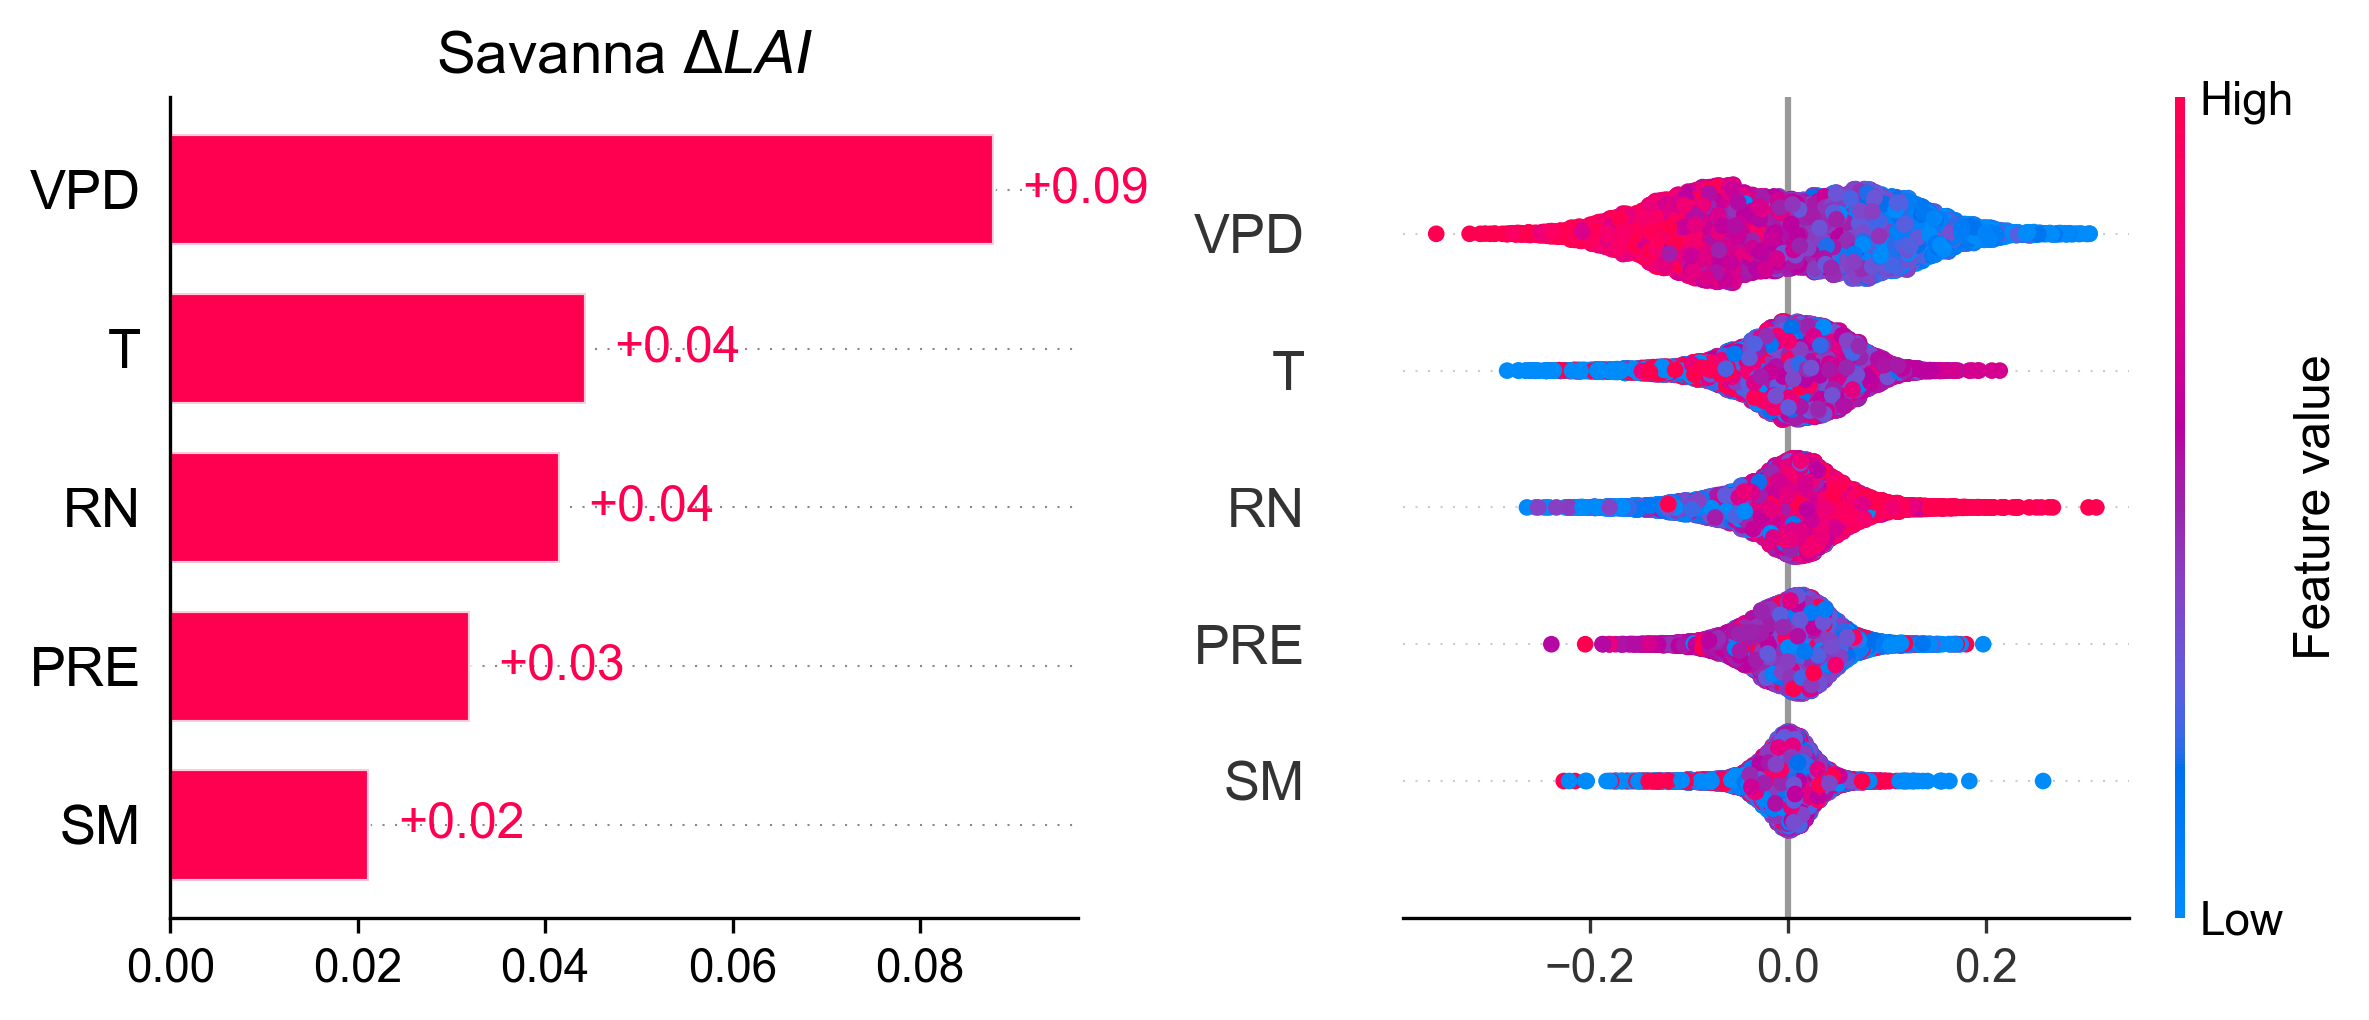

In [51]:
fig, axs = plt.subplots(1, 2, dpi=300, figsize=(6, 4))
shap.plots.bar(shap_values1, show=False, ax=axs[0])
axs[0].set_title("Savanna $\Delta LAI$", fontsize=14)
axs[0].set_xlabel('')
shap.summary_plot(shap_values_array1, X_sample1, show=False)
axs[1].set_xlabel('')
plt.tight_layout()
plt.savefig(outpath+'r1b1.eps', dpi=1000, bbox_inches='tight') 
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


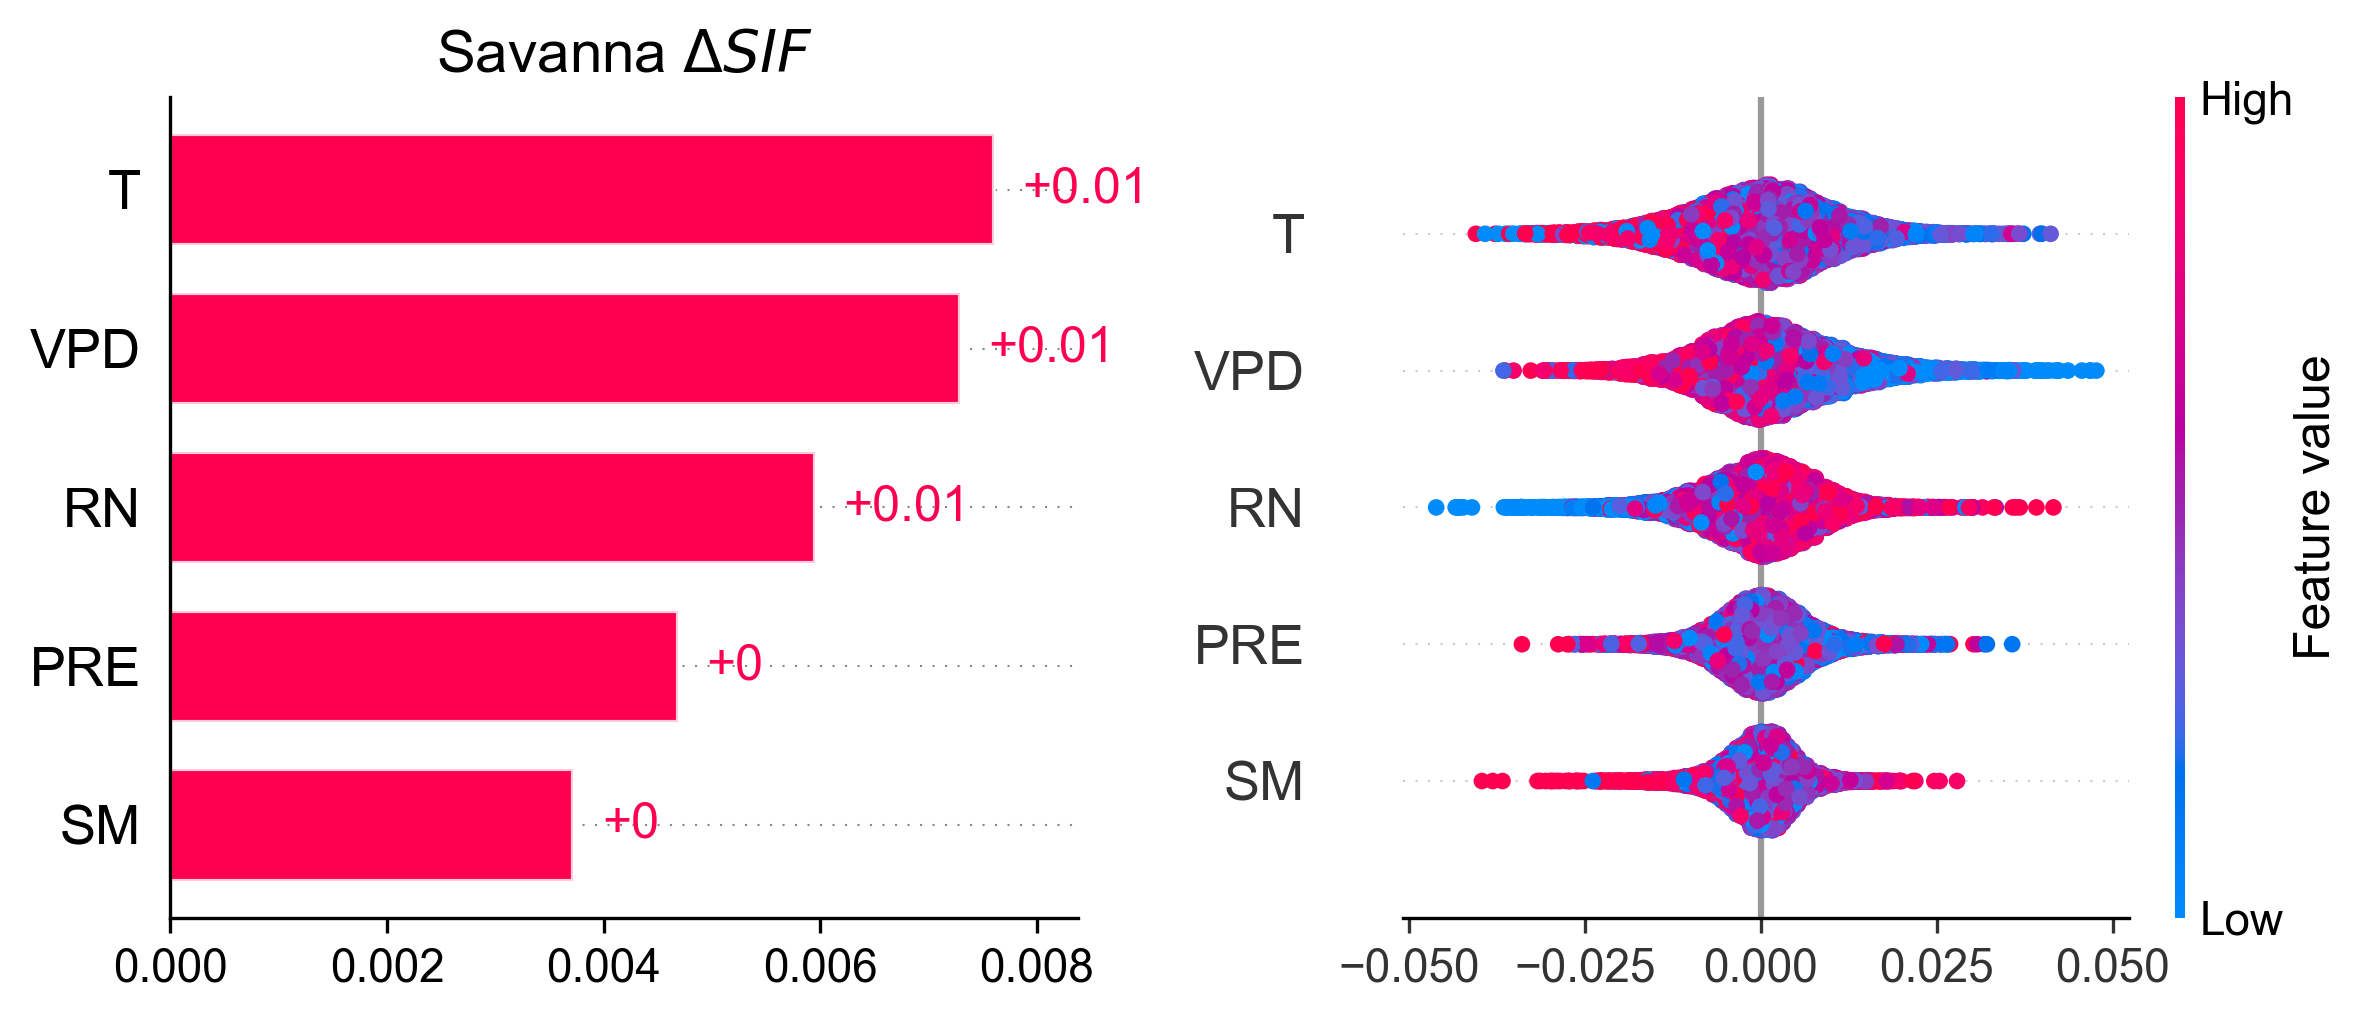

In [52]:
fig, axs = plt.subplots(1, 2, dpi=300, figsize=(6, 4))
shap.plots.bar(shap_values2, show=False, ax=axs[0])
axs[0].set_title("Savanna $\Delta SIF$", fontsize=14)
axs[0].set_xlabel('')
shap.summary_plot(shap_values_array2, X_sample2, show=False)
plt.gca().set_xlabel('')
plt.tight_layout()
plt.savefig(outpath+'r1b2.eps', dpi=1000, bbox_inches='tight') 
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


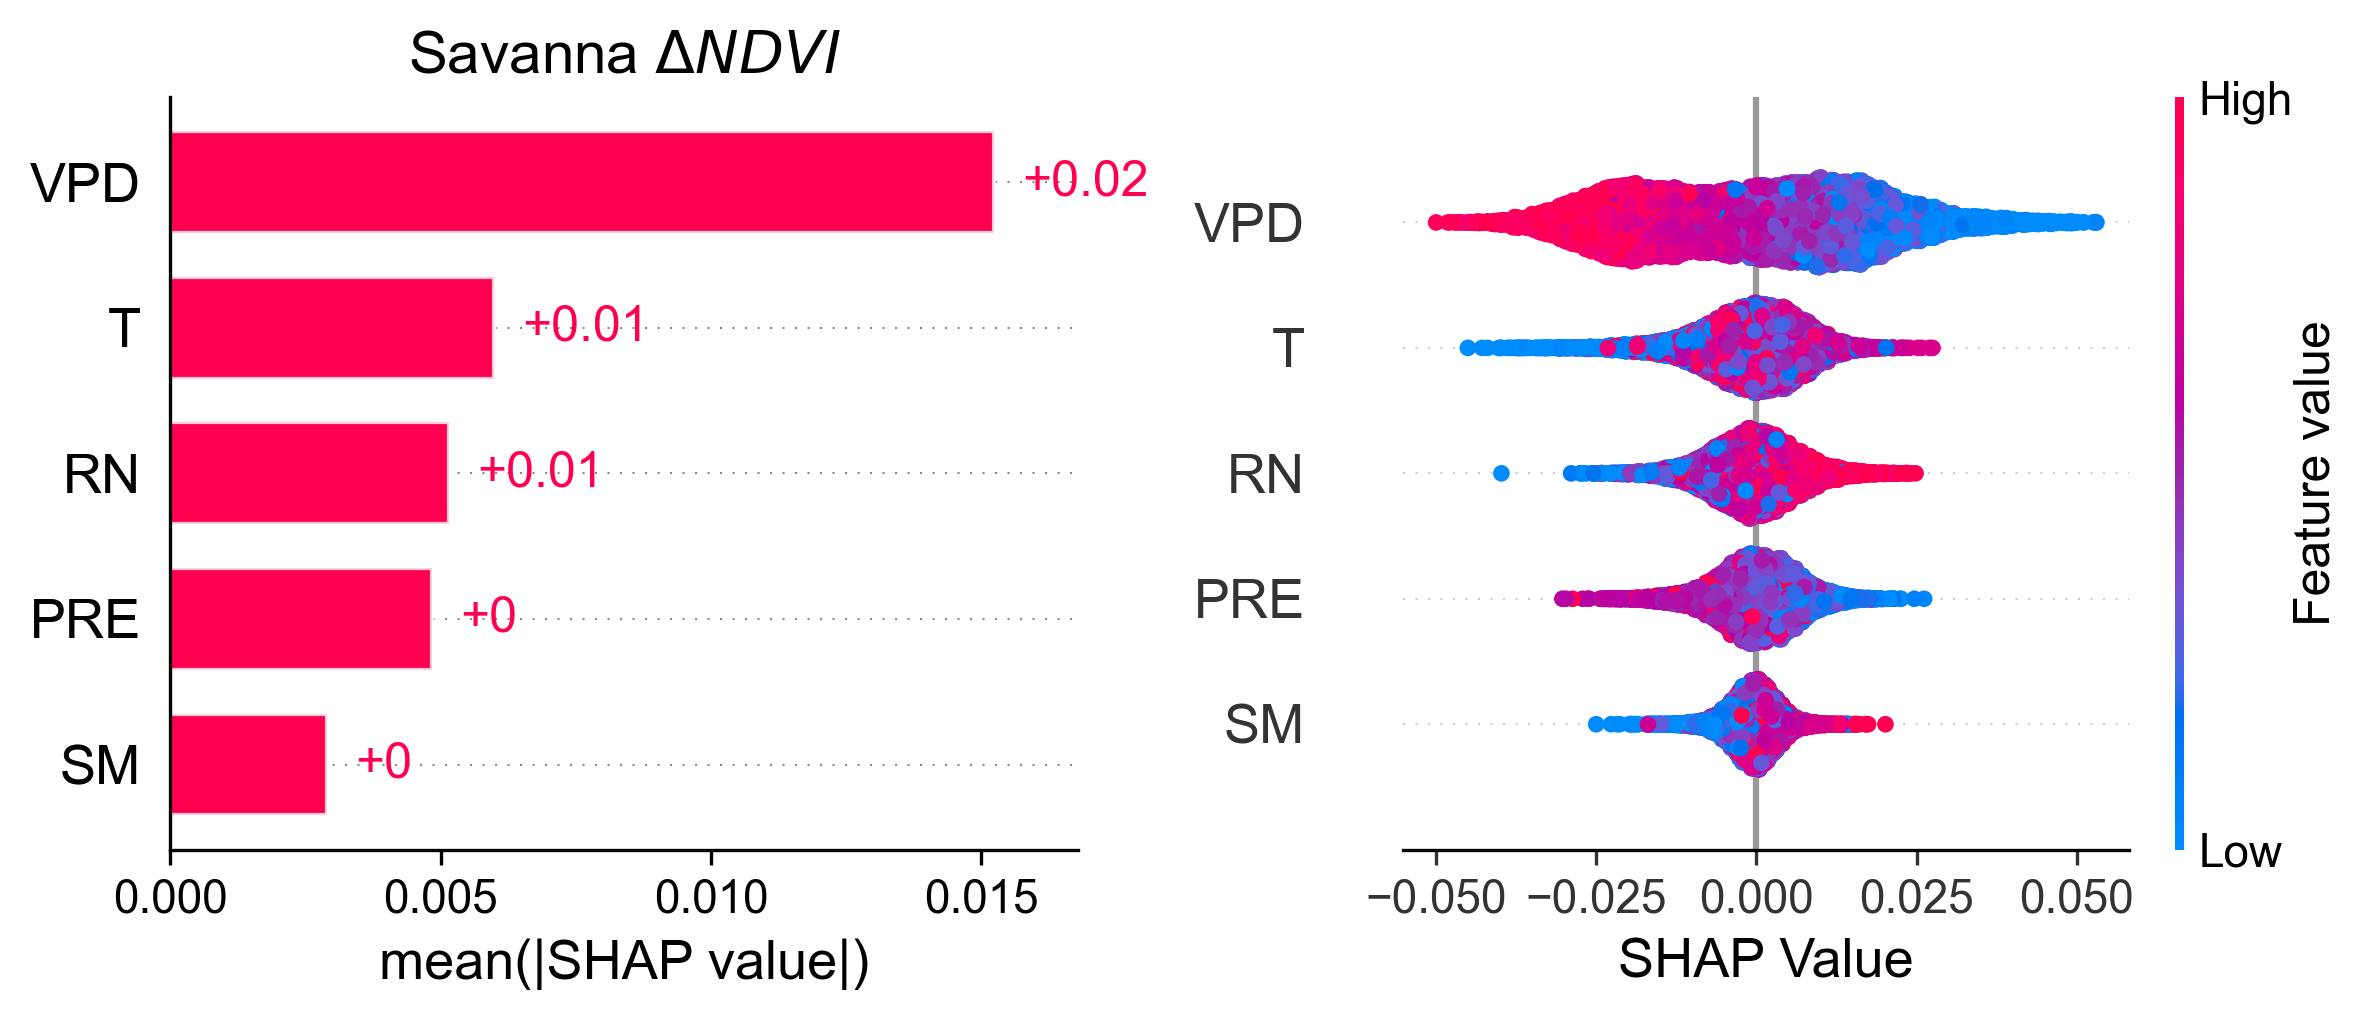

In [53]:
fig, axs = plt.subplots(1, 2, dpi=300, figsize=(6, 4))
shap.plots.bar(shap_values3, show=False, ax=axs[0])
axs[0].set_title("Savanna $\Delta NDVI$", fontsize=14)
shap.summary_plot(shap_values_array3, X_sample3, show=False)
plt.gca().set_xlabel('SHAP Value')
plt.tight_layout()
plt.savefig(outpath+'r1b3.eps', dpi=1000, bbox_inches='tight') 
plt.show()

In [54]:
################# x1-pre, x2-rn, x3-sm, x4-t, x5-vpd, y1-lai, y2-sif, y3-ndvi ##############################
ds_y1 = varimask_crop(y1_1).sel(time=slice('2022-07-01','2022-09-30'))
ds_y2 = varimask_crop(y2_1).sel(time=slice('2022-07-01','2022-09-30'))
ds_y3 = varimask_crop(y3_1).sel(time=slice('2022-07-01','2022-09-30'))
ds_x1 = varimask_crop(x1_1).sel(time=slice('2022-07-01','2022-09-30'))
ds_x2 = varimask_crop(x2_1).sel(time=slice('2022-07-01','2022-09-30'))
ds_x3 = varimask_crop(x3_1).sel(time=slice('2022-07-01','2022-09-30'))
ds_x4 = varimask_crop(x4_1).sel(time=slice('2022-07-01','2022-09-30'))
ds_x5 = varimask_crop(x5_1).sel(time=slice('2022-07-01','2022-09-30'))

y1_smooth = moving_window_mean(ds_y1['vari'], size=3)
y2_smooth = moving_window_mean(ds_y2['vari'], size=3)
y3_smooth = moving_window_mean(ds_y3['vari'], size=3)
x1_smooth = moving_window_mean(ds_x1['vari'], size=3)
x2_smooth = moving_window_mean(ds_x2['vari'], size=3)
x3_smooth = moving_window_mean(ds_x3['vari'], size=3)
x4_smooth = moving_window_mean(ds_x4['vari'], size=3)
x5_smooth = moving_window_mean(ds_x5['vari'], size=3)

arr_y1 = y1_smooth.values.flatten()
arr_y2 = y2_smooth.values.flatten()
arr_y3 = y3_smooth.values.flatten()
arr_x1 = x1_smooth.values.flatten()
arr_x2 = x2_smooth.values.flatten()
arr_x3 = x3_smooth.values.flatten()
arr_x4 = x4_smooth.values.flatten()
arr_x5 = x5_smooth.values.flatten()

df = pd.DataFrame({'y': arr_y1, 'PRE': arr_x1, 'RN': arr_x2, 'SM': arr_x3, 'T': arr_x4, 'VPD': arr_x5})
df1 = df.dropna()
df = pd.DataFrame({'y': arr_y2, 'PRE': arr_x1, 'RN': arr_x2, 'SM': arr_x3, 'T': arr_x4, 'VPD': arr_x5})
df2 = df.dropna()
df = pd.DataFrame({'y': arr_y3, 'PRE': arr_x1, 'RN': arr_x2, 'SM': arr_x3, 'T': arr_x4, 'VPD': arr_x5})
df3 = df.dropna()

Crop mask ratio: 41.56%
Crop mask ratio: 41.56%
Crop mask ratio: 41.56%
Crop mask ratio: 41.56%
Crop mask ratio: 41.56%
Crop mask ratio: 41.56%
Crop mask ratio: 41.56%
Crop mask ratio: 41.56%


In [59]:
X1 = df1[['PRE', 'RN', 'SM', 'T', 'VPD']]  
y = df1['y'].values
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(
    n_estimators=1500,       # number of trees
    max_depth=7,             # maximum depth of each tree
    learning_rate=0.1,      # shrinkage for boosting
    subsample=0.9,           # fraction of samples per tree
    colsample_bytree=0.8,    # fraction of features per tree
    gamma=0,                 # minimum loss reduction to make a split
    reg_alpha=0.5,              # L1 regularization
    reg_lambda=1,             # L2 regularization
    min_child_weight=4,       # minimum sum of instance weight in a child
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.6f}")

X_sample1 = X1.sample(20000, random_state=42)
explainer = shap.Explainer(xgb_model,X_sample1)
shap_values1 = explainer(X_sample1)
shap_values_array1 = shap_values1.values
shap_values_mean1 = np.abs(shap_values_array1).mean(axis=0)


X2 = df2[['PRE', 'RN', 'SM', 'T', 'VPD']]  
y = df2['y'].values
X_train, X_test, y_train, y_test = train_test_split(
    X2, y, test_size=0.2, random_state=42, shuffle=True)

xgb_model = xgb.XGBRegressor(
    n_estimators=1500,       # number of trees
    max_depth=7,             # maximum depth of each tree
    learning_rate=0.1,      # shrinkage for boosting
    subsample=0.9,           # fraction of samples per tree
    colsample_bytree=0.8,    # fraction of features per tree
    gamma=0,                 # minimum loss reduction to make a split
    reg_alpha=0.5,              # L1 regularization
    reg_lambda=1,             # L2 regularization
    min_child_weight=4,       # minimum sum of instance weight in a child
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.6f}")

X_sample2 = X2.sample(20000, random_state=42)
explainer = shap.Explainer(xgb_model,X_sample2)
shap_values2 = explainer(X_sample2)
shap_values_array2 = shap_values2.values
shap_values_mean2 = np.abs(shap_values_array2).mean(axis=0)


X3 = df3[['PRE', 'RN', 'SM', 'T', 'VPD']]  
y = df3['y'].values
X_train, X_test, y_train, y_test = train_test_split(
    X3, y, test_size=0.2, random_state=42, shuffle=True)

xgb_model = xgb.XGBRegressor(
    n_estimators=1500,       # number of trees
    max_depth=7,             # maximum depth of each tree
    learning_rate=0.1,      # shrinkage for boosting
    subsample=0.9,           # fraction of samples per tree
    colsample_bytree=0.8,    # fraction of features per tree
    gamma=0,                 # minimum loss reduction to make a split
    reg_alpha=0.5,              # L1 regularization
    reg_lambda=1,             # L2 regularization
    min_child_weight=4,       # minimum sum of instance weight in a child
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.6f}")

X_sample3 = X3.sample(20000, random_state=42)
explainer = shap.Explainer(xgb_model,X_sample3)
shap_values3 = explainer(X_sample3)
shap_values_array3 = shap_values3.values
shap_values_mean3 = np.abs(shap_values_array3).mean(axis=0)

R²: 0.7210
MSE: 0.019971


100%|===================| 19994/20000 [26:56<00:00]        

R²: 0.7003
MSE: 0.000259


100%|===================| 19995/20000 [32:20<00:00]        

R²: 0.6477
MSE: 0.000882


100%|===================| 19997/20000 [30:36<00:00]        

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


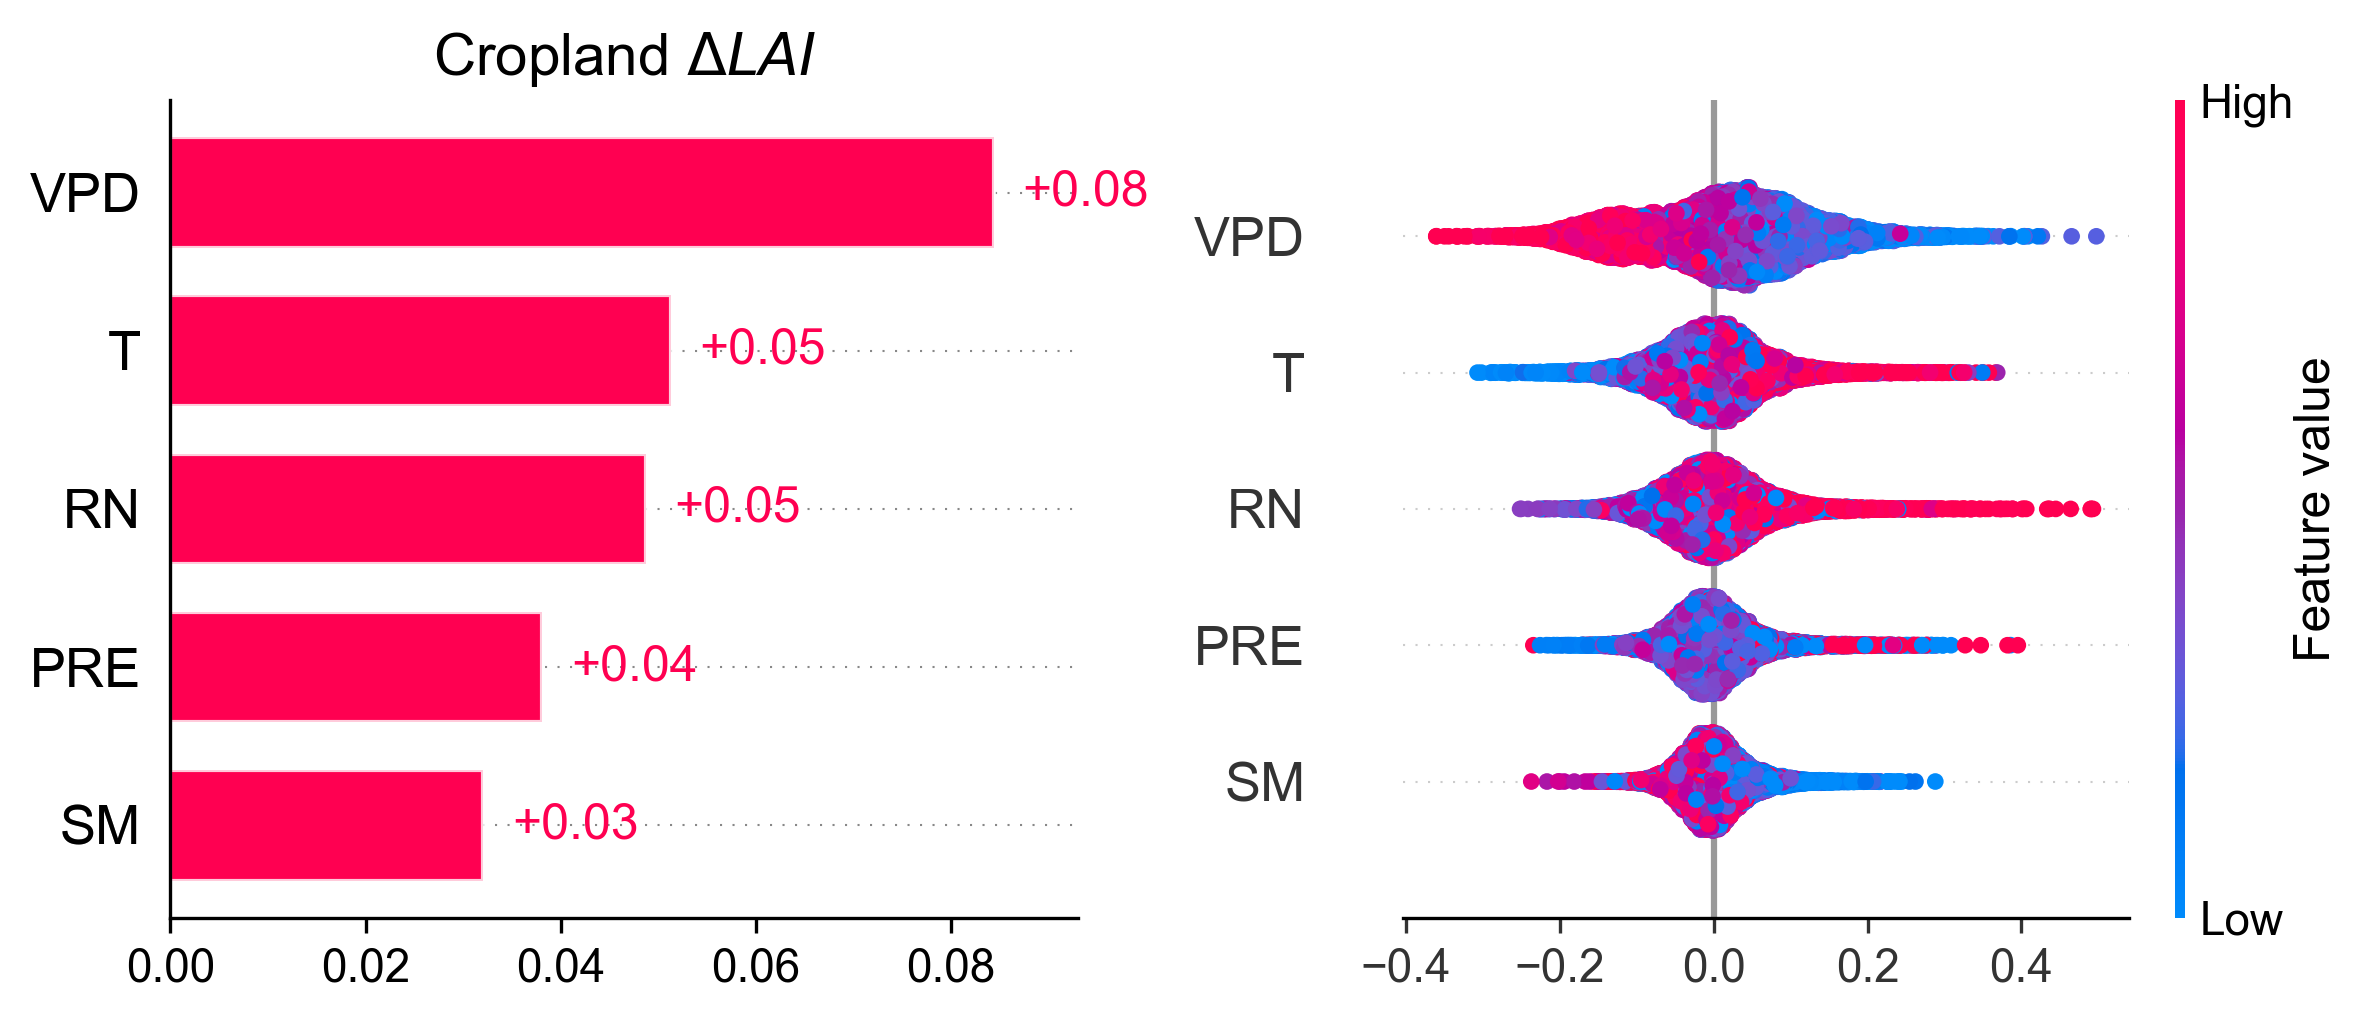

In [60]:
fig, axs = plt.subplots(1, 2, dpi=300, figsize=(6, 4))
shap.plots.bar(shap_values1, show=False, ax=axs[0])
axs[0].set_title("Cropland $\Delta LAI$", fontsize=14)
axs[0].set_xlabel('')
shap.summary_plot(shap_values_array1, X_sample1, show=False)
axs[1].set_xlabel('')
plt.tight_layout()
plt.savefig(outpath+'r1c1.eps', dpi=1000, bbox_inches='tight') 
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


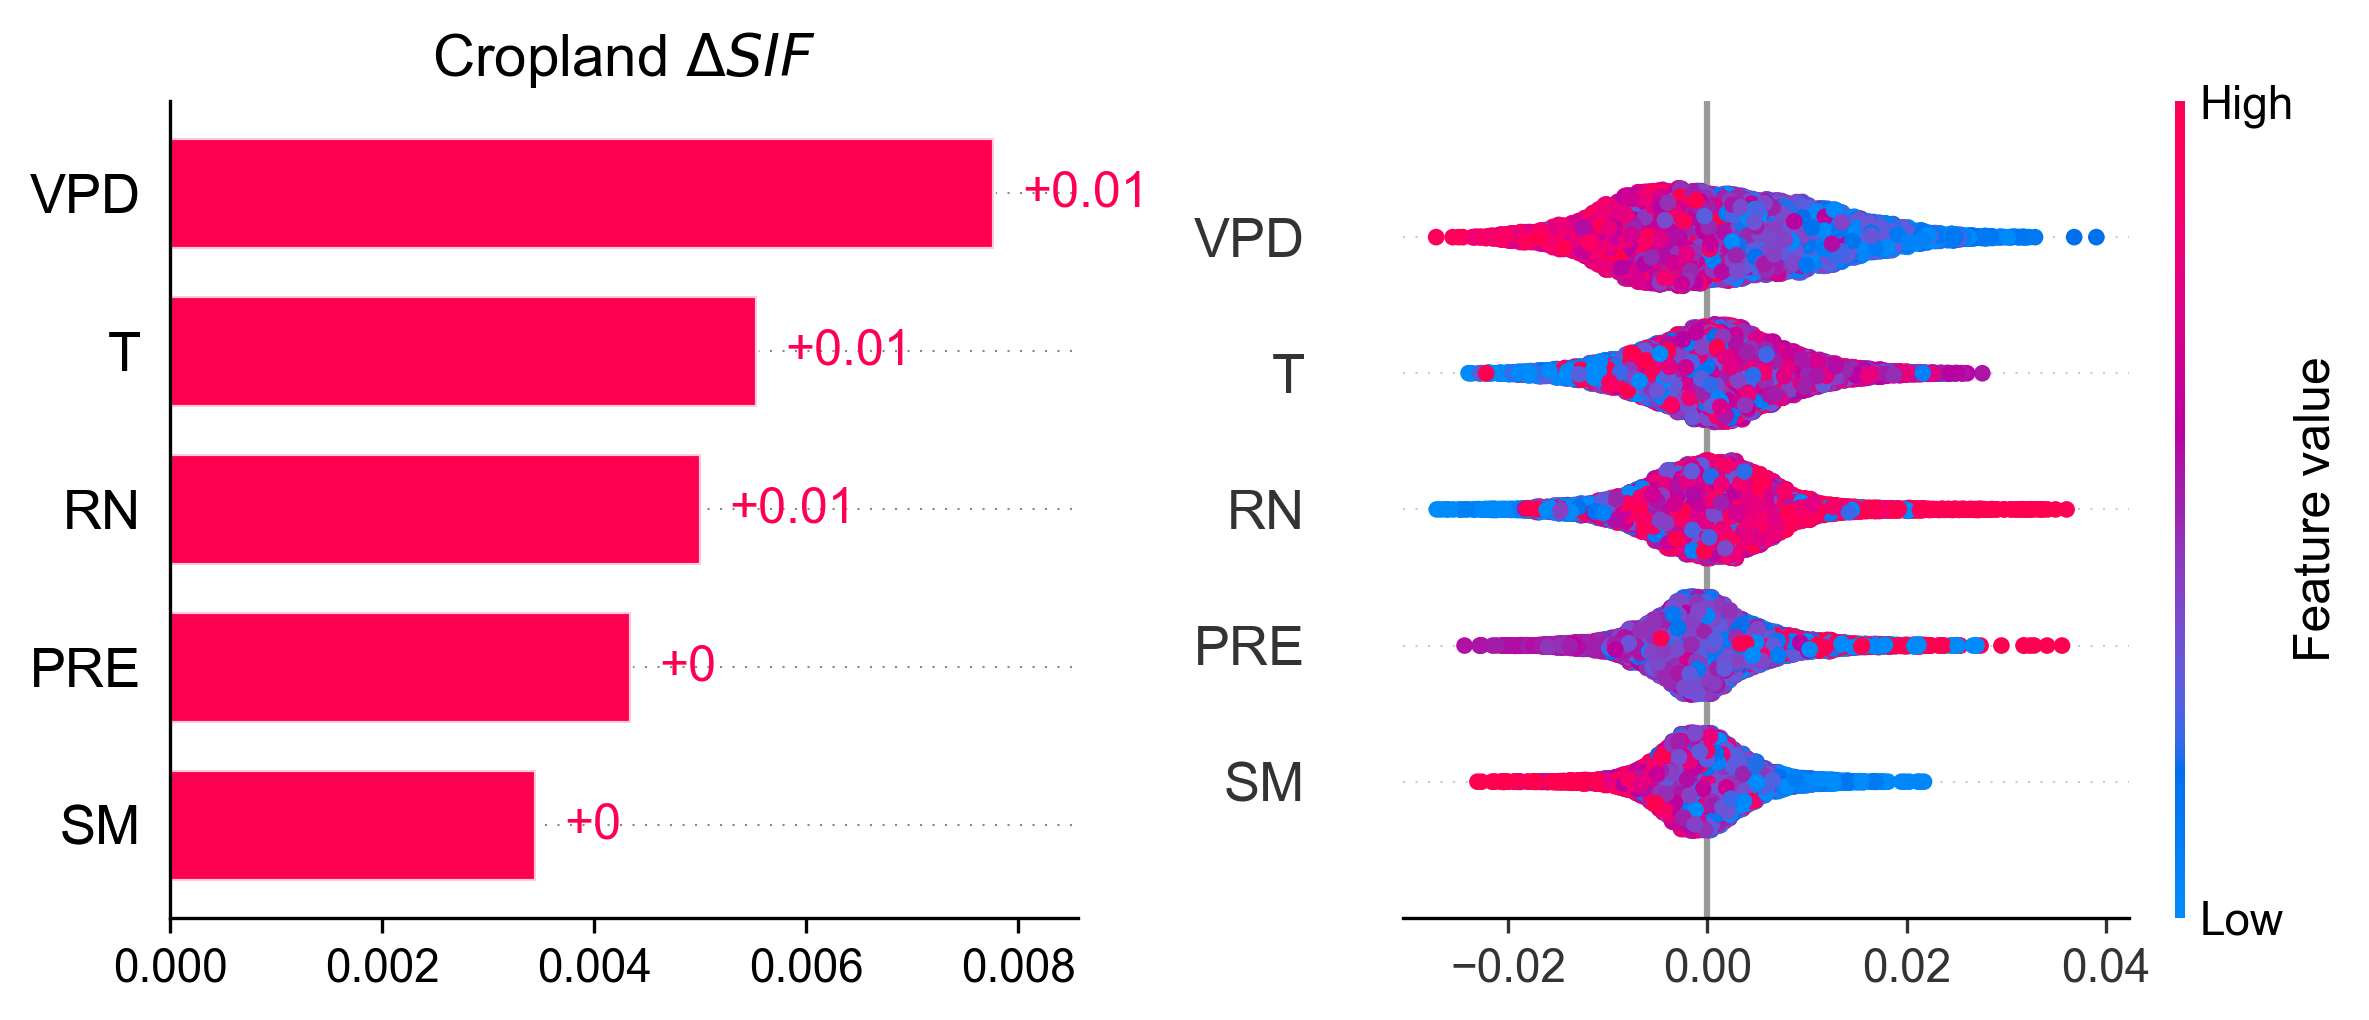

In [61]:
fig, axs = plt.subplots(1, 2, dpi=300, figsize=(6, 4))
shap.plots.bar(shap_values2, show=False, ax=axs[0])
axs[0].set_title("Cropland $\Delta SIF$", fontsize=14)
axs[0].set_xlabel('')
shap.summary_plot(shap_values_array2, X_sample2, show=False)
plt.gca().set_xlabel('')
plt.tight_layout()
plt.savefig(outpath+'r1c2.eps', dpi=1000, bbox_inches='tight') 
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


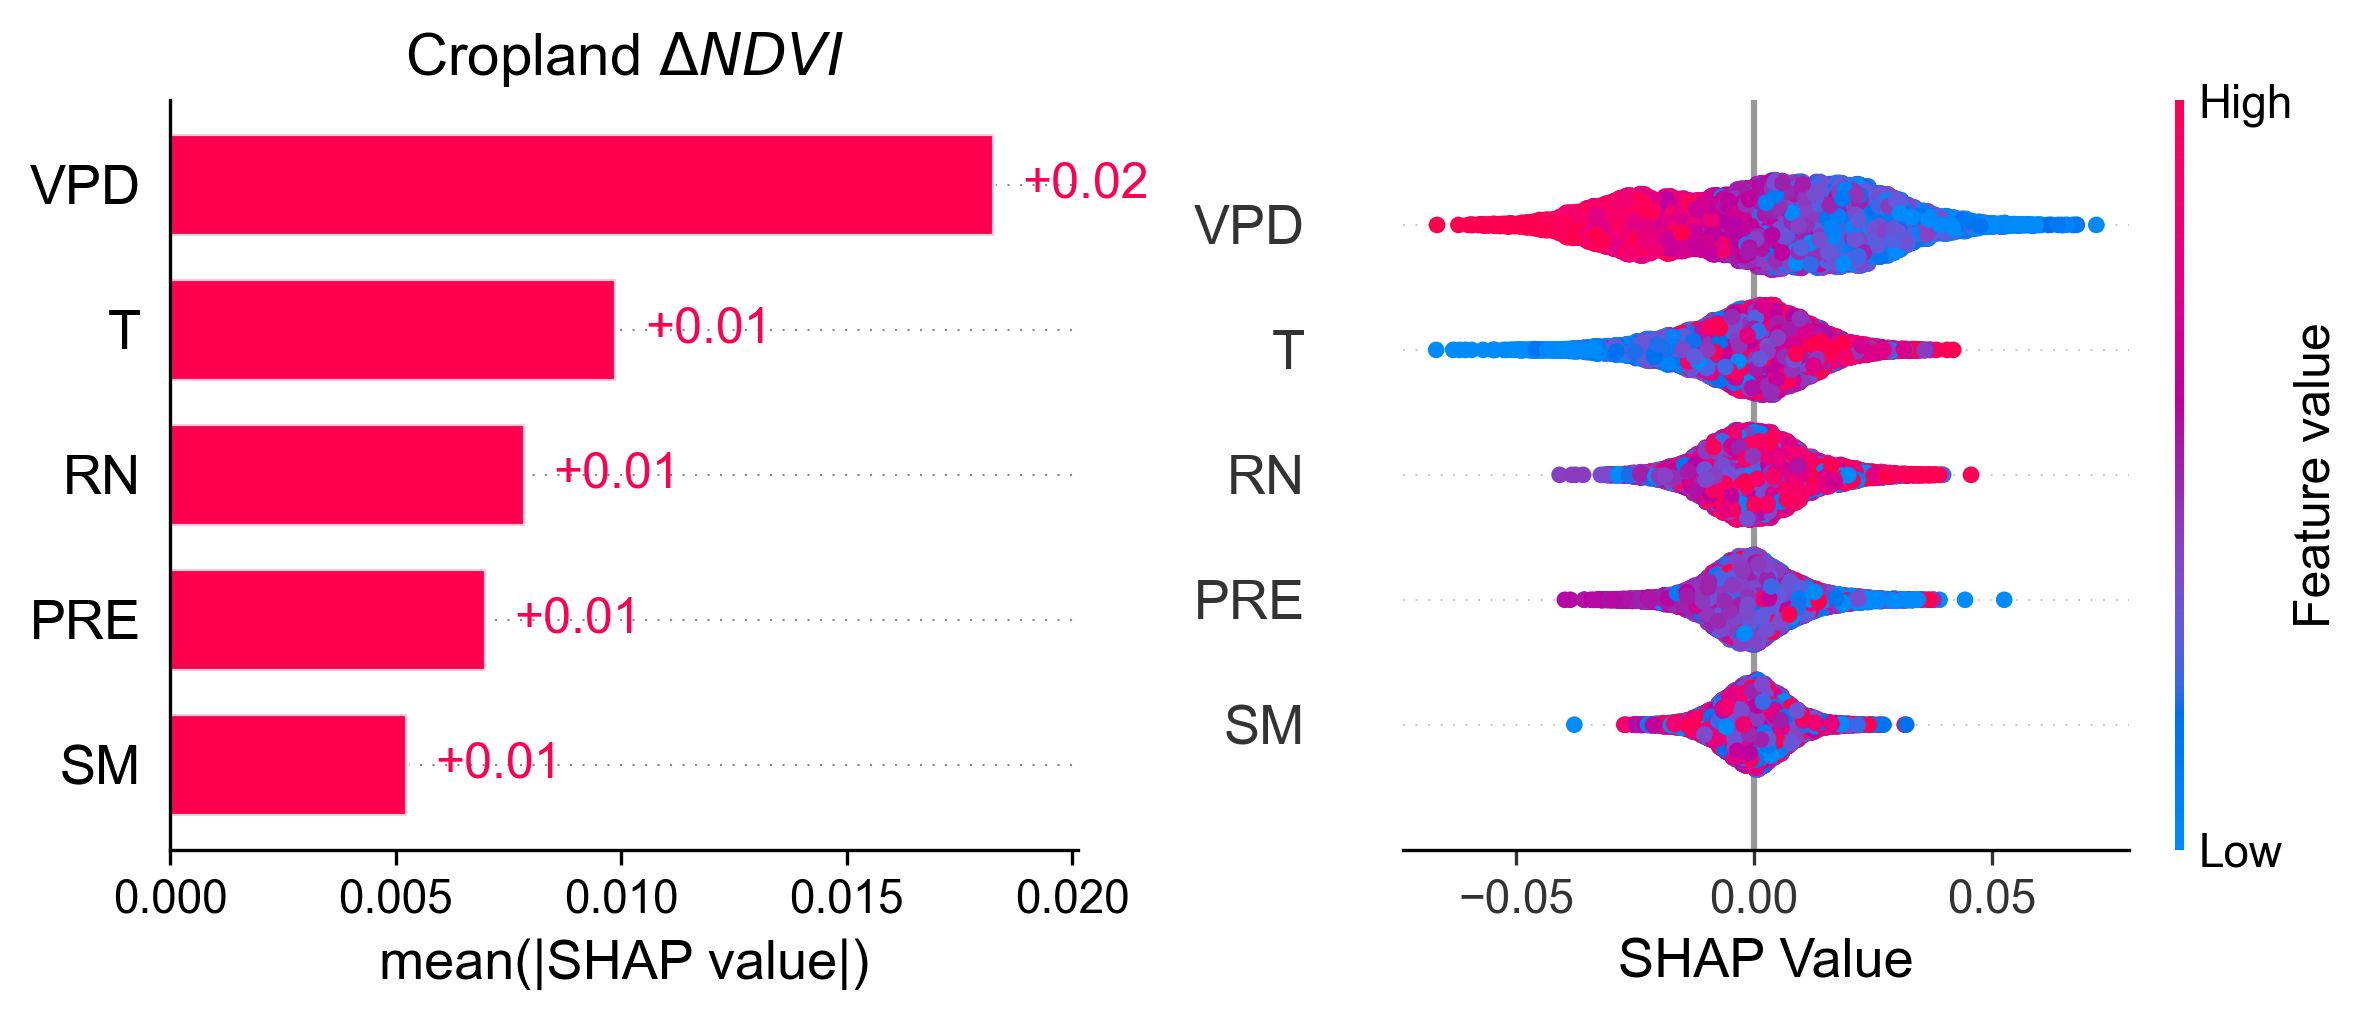

In [62]:
fig, axs = plt.subplots(1, 2, dpi=300, figsize=(6, 4))
shap.plots.bar(shap_values3, show=False, ax=axs[0])
axs[0].set_title("Cropland $\Delta NDVI$", fontsize=14)
shap.summary_plot(shap_values_array3, X_sample3, show=False)
plt.gca().set_xlabel('SHAP Value')
plt.tight_layout()
plt.savefig(outpath+'r1c3.eps', dpi=1000, bbox_inches='tight') 
plt.show()